# GPT-2

In [29]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from datasets import Dataset, DatasetDict
import datetime

In [30]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

model_name = "openai-community/gpt2"

config = {
    "per_device_train_batch_size":8,
    "per_device_eval_batch_size":8,
    "num_train_epochs":2,
    "learning_rate":5e-5,
    "maxlen": 1000,
    "logging_steps": 10,
    "num_classes": 6,
    "num_labels":6,
    "use_cache":False,
    "pretraining_tp":1,
    "model_name": model_name
}

run = wandb.init(
    project='wz_experimental',
    config=config
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▃▂▂▂▁▃▅▃▃▃▆▂▃▂▃▃▃▂▃▁▃▄▃▂▂▃▃▆▁▂▃▂▂▂▃▆▃▃
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▅▄▃▂▃▃▃▃▂▂▂▂▂▂▂▃▂▃▂▂▁▂▂▂▂▁▂▁▁▂▂▂▂▂▂▂▂▂▁
train/epoch,0.99653
train/global_step,2010
train/grad_norm,32.59973
train/learning_rate,3e-05
train/loss,0.7041


In [31]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [32]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [33]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 16130
    })
    val: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2091
    })
    test: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2692
    })
})

In [34]:
def check_labels_range(dataset):
    unique_labels = set(dataset['train']['label'])
    print(f"Unique labels in the training dataset: {unique_labels}")
    assert all(label in range(6) for label in unique_labels), "Labels must be in the range 0 to 5"

check_labels_range(dataset)

Unique labels in the training dataset: {0, 1, 2, 3, 4, 5}


In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6, config=config)
model.to(device)
print("Added to device")

Using device: cuda


C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Added to device


In [36]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [37]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [38]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=config['maxlen'])

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['text'])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

Map:   0%|          | 0/2091 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

In [39]:
def compute_metrics(pred):
    print(pred)
    print(f'Label: {str(pred.label_ids)[:60]}')
    print(f'Pred: {str(pred.predictions)[:60]}')
    print(f'Input: {str(pred.inputs)[:60]}')
    labels = pred.label_ids
    predictions = pred.predictions.argmax(-1)

    m_accuracy = accuracy_score(labels, predictions)

    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': m_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [40]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_steps=config['logging_steps'],
    per_device_train_batch_size=config['per_device_train_batch_size'],
    per_device_eval_batch_size=config['per_device_eval_batch_size'],
    num_train_epochs=config['num_train_epochs'],
    fp16=True,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=config['learning_rate'],
)

In [41]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed=42),
    eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics
)

C:\Users\kawis\anaconda3\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [42]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682900,0.634342,0.739837,0.740936,0.739837,0.738828
2,0.488200,0.594133,0.769010,0.767030,0.769010,0.767273


Label: [1 0 1 ... 0 0 4]
Pred: [[ 3.5820312   4.8125      0.52783203 -3.3046875  -6.359375 
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Label: [1 0 1 ... 0 0 4]
Pred: [[ 4.0390625   6.4257812   0.44580078 -4.859375   -6.3828125
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
trainer.evaluate()

Label: [1 0 1 ... 0 0 4]
Pred: [[ 4.0390625   6.4257812   0.44580078 -4.859375   -6.3828125
Input: None


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5941333174705505,
 'eval_accuracy': 0.7690100430416069,
 'eval_precision': 0.7670304936697022,
 'eval_recall': 0.7690100430416069,
 'eval_f1': 0.7672725371155668,
 'eval_runtime': 9.405,
 'eval_samples_per_second': 222.328,
 'eval_steps_per_second': 27.857,
 'epoch': 2.0}

In [44]:
model.config.use_cache = True

In [45]:
trainer.save_model('model')
tokenizer.save_pretrained('model')

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.json',
 'model\\merges.txt',
 'model\\added_tokens.json')

In [46]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=1000)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])

    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-29 19:36:20.966185


Accuracy: 0.746
Accuracy for label A1: 0.904
Accuracy for label A2: 0.675
Accuracy for label B1: 0.581
Accuracy for label B2: 0.768
Accuracy for label C1: 0.669
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.86      0.90      0.88       853
          A2       0.76      0.67      0.71       753
          B1       0.59      0.58      0.59       442
          B2       0.71      0.77      0.74       492
          C1       0.62      0.67      0.65       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.75      2692
   macro avg       0.59      0.60      0.59      2692
weighted avg       0.74      0.75      0.74      2692


Confusion Matrix:
[[771  80   2   0   0   0]
 [127 508 111   7   0   0]
 [  2  78 257 102   3   0]
 [  0   6  63 378  45   0]
 [  0   0   3  44  95   0]
 [  0   0   0   1   9   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

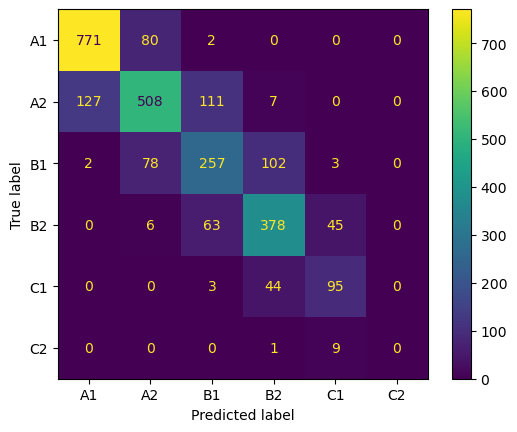

In [47]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

unique_labels = set(y_true_mapped)

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)


print('\nClassification Report:')
print(class_report)


table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [48]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-29 19:36:33.503739


eval/accuracy,▁██
eval/f1,▁██
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁██
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▄▃▁▂▃▃▄▁▆▃▄▄▁▂▃▃▄▄▅▂▂▂▁▄▃▄▂▂▂█▂▃▂▄▂▆▃▃▄▁
